INFO:root:__init__: Constructor of GenIce.
INFO:root:  
INFO:root:  Test ice 1h
INFO:root:No rotmatrices in lattice
INFO:root:Cell dimension:
INFO:root:  a = 7.84813412606925
INFO:root:  b = 7.37735062301457
INFO:root:  c = 9.06573834219084
INFO:root:  A = 90.0
INFO:root:  B = 90.0
INFO:root:  C = 90.0
INFO:root:HB connectivity is not defined.
INFO:root:Bond length (specified): 3
INFO:root:Target Density: 0.92
INFO:root:Original Density: 0.0009111328713390615
INFO:root:Bond length (scaled, nm): 0.29903306849378936
INFO:root:__init__: end.
INFO:root:__init__: 25 ms
INFO:root:Stage1: Replicate water molecules to make a repeated cell.
INFO:root:  Number of water molecules: 432
INFO:root:  Pairs are not given explicitly.
INFO:root:  Estimating the bonds according to the pair distances.
INFO:root:  Number of water nodes: 16
INFO:root:Cell dimension:
INFO:root:  a = 0.7822838765564372
INFO:root:  b = 0.7353572647182051
INFO:root:  c = 0.9036518515423753
INFO:root:  A = 90.0
INFO:root:  B = 9

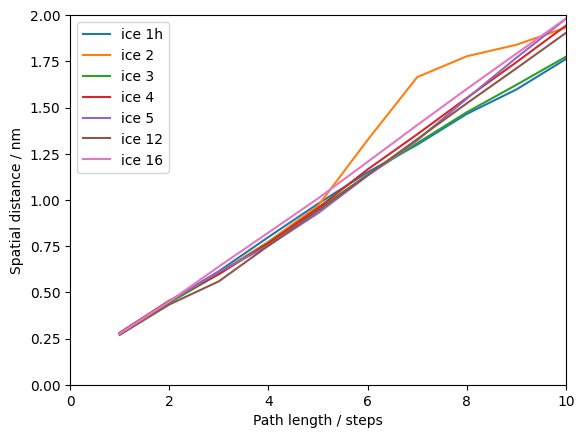

In [18]:
# Generate various ice types.

import itertools as it
from logging import DEBUG, INFO, WARNING, getLogger

from genice2.genice import GenIce
from genice2.plugin import Format, Lattice
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

logger = getLogger()
logger.setLevel(INFO)

for icetype in ("1h", "2", "3", "4", "5", "12", "16"):
    if icetype == "16":
        rep = (2,2,2)
    elif icetype in ("2", "3", "12"):
        rep = (4,4,4)
    else:
        rep = (3,3,3)
    lattice    = Lattice(icetype)
    formatter  = Format("raw", stage=(1,2))
    raw = GenIce(lattice, rep=rep, signature=f"Test ice {icetype}").generate_ice(formatter)

    # distance on the graph
    g = nx.Graph(raw["graph"])
    D = dict(nx.all_pairs_shortest_path_length(g))
    nnode = len(g.nodes)
    table = np.zeros([nnode, nnode])
    for i in D:
        for j, d in D[i].items():
            table[i,j] = d
            table[j,i] = d

    # spatial distance
    cell = raw["repcell"]
    rpos = raw["reppositions"]

    table2 = np.zeros([nnode, nnode])
    for i, j in it.combinations(range(nnode), 2):
        d = rpos[i] - rpos[j]
        d -= np.floor(d+0.5)
        dist = np.linalg.norm(d @ cell)
        table2[i,j] = dist
        table2[j,i] = dist

    hist = dict()
    for i, j in it.combinations(range(nnode), 2):
        dtopo = table[i,j]
        if dtopo not in hist:
            hist[dtopo] = []
        dgeom = table2[i,j]
        hist[dtopo].append(dgeom)
    # print(hist[1])
    # print(nnode)
    # print(len(rpos))

    X = sorted(hist.keys())
    Y = [np.mean(hist[x]) for x in X]
    plt.plot(X, Y, label=f"ice {icetype}")
    # assert False

plt.xlim(0,10)
plt.ylim(0,2)
plt.xlabel("Path length / steps")
plt.ylabel("Spatial distance / nm")
plt.legend()

